In [1]:
#Les imports 

%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from utils import *
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn import preprocessing

from dataset_prepare import load_dataset, pred_thres, test_train_sets

In [2]:
df_2 = load_dataset()
label = 'mortal'

/home/erwan/Fairness/projet/fairness/dataset_prepare.py:18: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("dataset/lieux-2022.csv", sep=';')


In [3]:
# Récupération des ensembles de train/test
X_train, X_test, y_train, y_test = test_train_sets(df_2)
df_2 = df_2.drop(columns='Num_Acc')

In [4]:
# valeurs catégorielles
categorical_features = ['trajet', 'catr', 'circ', 'nbv', 'prof',
                        'plan', 'surf', 'vma', 'lum', 'agg', 
                        'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton',
                        'sexe_conducteur', 'infra', 'situ']
# valeurs numériques
numerical_features = ['mois', 'dep','age']

print("numerical : ", numerical_features)
print("categorical : ", categorical_features)

numerical :  ['mois', 'dep', 'age']
categorical :  ['trajet', 'catr', 'circ', 'nbv', 'prof', 'plan', 'surf', 'vma', 'lum', 'agg', 'int', 'atm', 'col', 'catv', 'obs', 'obsm', 'choc', 'pieton', 'sexe_conducteur', 'infra', 'situ']


In [5]:
from utils import custom_RFC

clf = pickle.load(open('models/rfc_model.sav', 'rb'))
preds = clf.predict(X_test)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.9975081988296572, 0.8789214074317658)

In [6]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
tn, fp, fn, tp

(26094, 2623, 1059, 634)

In [7]:
import plotly.express as px

fig = px.imshow([[tn, fp], [fn, tp]], text_auto=True, labels=dict(y="Truth", x="Pred"),
                x=["False", "True"],
                y=["False", "True"]
               )
fig.show()

- RandomForest: 26326, 3009, 1002, 702

In [8]:
encoders = {cat_col:preprocessing.LabelEncoder() for cat_col in categorical_features}

for cat_col in categorical_features:
  df_2[cat_col] = encoders[cat_col].fit_transform(df_2[cat_col])
  print(cat_col)
  for idx in sorted(df_2[cat_col].unique()):
    print(idx, encoders[cat_col].inverse_transform([idx]))

trajet
0 [0]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
catr
0 [1]
1 [2]
2 [3]
3 [4]
4 [5]
circ
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
nbv
0 [-1]
1 [0]
2 [1]
3 [2]
4 [3]
5 [4]
6 [5]
7 [6]
8 [7]
9 [8]
10 [9]
11 [10]
12 [11]
13 [12]
prof
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
plan
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
surf
0 [0]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
8 [8]
vma
0 [1]
1 [2]
2 [3]
3 [4]
lum
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
agg
0 [1]
1 [2]
int
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
8 [8]
9 [9]
atm
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
8 [8]
9 [9]
col
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [7]
catv
0 [0]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
obs
0 [0]
1 [1]
obsm
0 [-1]
1 [0]
2 [1]
3 [2]
4 [4]
5 [5]
6 [6]
7 [9]
choc
0 [-1]
1 [0]
2 [1]
3 [2]
4 [3]
5 [4]
6 [5]
7 [6]
8 [7]
9 [8]
10 [9]
pieton
0 [0]
1 [1]
sexe_conducteur
0 [0]
1 [1]
infra
0 [-1]
1 [0]
2 [1]
3 [2]
4 [3]
5 [4]
6 [5]
7 [6]
8 [7]
9 [8]
10 [9]
situ
0 [-1]
1 [1]
2 [2]
3 [3]
4 [4]
5 [5]
6 [6]
7 [8]


In [9]:
def compute_stat(preds, sensitive, value=None, not_value=None):
    if value is not None:
      preds_sel = preds[sensitive == value]
    elif not_value is not None:
      preds_sel = preds[sensitive != not_value]
    else:
      print("one of 'value' and 'not value' must be set")
      return None, None, None, None
    card = len(preds_sel)
    card_pos = len(preds_sel[preds_sel == 1])
    card_neg = len(preds_sel[preds_sel == 0])
    return card, card_pos, card_neg, preds_sel


def compute_baserate(preds, sensitive=X_test["sexe_conducteur"], value=0):

    n_F, n_F_pos, n_F_neg, preds_F = compute_stat(preds=preds, sensitive=sensitive, value=value)
    n_M, n_M_pos, n_M_neg, preds_M = compute_stat(preds=preds, sensitive=sensitive, not_value=value)

    DI = n_F_pos/n_F*n_M/n_M_pos
    p_DI = np.min([DI, 1/DI])
    DP = n_F_pos/n_F - n_M_pos/n_M

    ret = {}
    ret["disparate_impact"] = DI
    ret["P_rule_disparate_impact"] = p_DI
    ret["demography_parity"] = DP

    return ret

In [10]:
preds = clf.predict(X_test)
for att,unpriv in zip(['sexe_conducteur', 'pieton'],[1, 1]):
  value = encoders[att].transform([unpriv])[0]
  base_rate_pred = compute_baserate(preds, sensitive=X_test[att], value=value)
  base_rate_label = compute_baserate(y_test, sensitive=X_test[att], value=value)
  print(att, unpriv)
  for k,v in base_rate_pred.items():
    print(k, v, base_rate_label[k])

sexe_conducteur 1
disparate_impact 2.090086701672976 1.5733869178937117
P_rule_disparate_impact 0.4784490515152152 0.6355715740529335
demography_parity 0.06474008293256608 0.022439373005842936
pieton 1
disparate_impact 0.7567953556406355 1.0800450805571133
P_rule_disparate_impact 0.7567953556406355 0.9258872782274753
demography_parity -0.026669891712500324 0.004422364056385214


In [11]:
import pickle

data_test = X_test.copy(deep=True)
data_test["Y"] = y_test

data_test.to_csv("test_data.csv",
          index=False)

data_train = X_train.copy(deep=True)
data_train["Y"] = y_train

data_train.to_csv("train_data.csv",
          index=False)

with open( 'clf.pickle', 'wb' ) as f:
    pickle.dump(clf, f )

In [12]:
import dice_ml
from dice_ml.utils import helpers
from IPython.core.display import HTML

In [16]:
train_dataset = X_train.copy(deep=True)
train_dataset[label] = y_train

d = dice_ml.Data(dataframe=train_dataset, continuous_features=numerical_features, outcome_name=label)

m = dice_ml.Model(model=clf, backend="sklearn")

exp = dice_ml.Dice(d, m, method="random")

In [24]:
# valeurs prédites vraies
p = []
predict = clf.predict(X_test)
for i in range(0, len(predict)):
    if predict[i] == 1.:
        p.append(i)

In [26]:
for i in range(0, 5):
    r = random.randint(0, 1000)
    e1 = exp.generate_counterfactuals(X_test[p[r]:p[r]+1], total_CFs=10, desired_class="opposite")
    e1.visualize_as_dataframe(show_only_changes=True)
    pd.set_option("display.max_rows", None, "display.max_columns", None)
    imp = exp.local_feature_importance(X_test[p[i]:p[i]+1], cf_examples_list=e1.cf_examples_list)
    print(imp.local_importance)

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:01<00:00,  1.35s/it]

Query instance (original outcome : 0)


trajet  catr  circ  nbv  prof  plan  surf  infra  situ  vma  mois  lum  \
0       5     3     2    2     1     1     1      5     1    3     8    1   

   dep  agg  int  atm  col  catv  obs  obsm  choc  pieton  sexe_conducteur  \
0   28    1    2    1    3     3    0     2     1       0                1   

    age  mortal  
0  65.0       0


Diverse Counterfactual set (new outcome: 1)


trajet catr circ nbv prof plan surf infra situ vma mois lum    dep agg int  \
0      -    -    -   -    -    -    -     -    -   -  7.0   -      -   -   -   
1      -    -    -   -    -    -    -     -    -   -  5.0   -      -   -   -   
2      -    -    -   -    -    -    -     -    -   -  7.0   -      -   -   -   
3      -    -    -   -    -    -    -     -    -   -  7.0   -      -   -   -   
4      -    -    -   -    -    -    -     -  4.0   -  7.0   -      -   -   -   
5      -    -    -   -    -    -    -     -  2.0   -  7.0   -      -   -   -   
6      -    -    -   -    -    -    -     -    -   -  7.0   -      -   -   -   
7      -    -    -   -    -    -    -     -    -   -  7.0   -  888.0   -   -   
8      -    -    -   -    -    -    -     -  4.0   -  7.0   -  888.0   -   -   
9      -    -    -   -    -    -    -     -  4.0   -  7.0   -  888.0   -   -   

   atm col catv  obs obsm choc pieton sexe_conducteur age mortal  
0    -   -    -    -    -    -      -               -   -    1.0  
1    -   -    -    -    -    -      -               -   -    1.0  
2    -   -    -    -  4.0    -      -               -   -    1.0  
3    -   -    -    -  6.0    -      -               -   -    1.0  
4    -   -    -    -    -    -      -               -   -    1.0  
5    -   -    -    -    -    -      -               -   -    1.0  
6  6.0   -    -    -    -    -      -               -   -    1.0  
7  4.0   -    -    -    -    -      -               -   -    1.0  
8  4.0   -    -    -    -    -      -               -   -    1.0  
9  4.0   -    -  1.0    -    -      -               -   -    1.0

[{'mois': 1.0, 'situ': 0.4, 'atm': 0.4, 'dep': 0.3, 'obsm': 0.2, 'obs': 0.1, 'trajet': 0.0, 'catr': 0.0, 'circ': 0.0, 'nbv': 0.0, 'prof': 0.0, 'plan': 0.0, 'surf': 0.0, 'infra': 0.0, 'vma': 0.0, 'lum': 0.0, 'agg': 0.0, 'int': 0.0, 'col': 0.0, 'catv': 0.0, 'choc': 0.0, 'pieton': 0.0, 'sexe_conducteur': 0.0, 'age': 0.0}]


100%|██████████| 1/1 [00:00<00:00,  1.40it/s]

Query instance (original outcome : 0)


trajet  catr  circ  nbv  prof  plan  surf  infra  situ  vma  mois  lum  \
0       0     3     2    2     1     1     1      0     3    3     2    1   

   dep  agg  int  atm  col  catv  obs  obsm  choc  pieton  sexe_conducteur  \
0   35    1    1    1    6     3    1     0     3       0                1   

    age  mortal  
0  21.0       0


Diverse Counterfactual set (new outcome: 1)


trajet catr circ nbv prof plan surf infra situ  vma mois lum dep agg int  \
0    5.0    -    -   -    -  2.0    -     -    -    -    -   -   -   -   -   
1    2.0    -    -   -    -    -    -     -    -    -  1.0   -   -   -   -   
2    4.0    -    -   -    -    -    -     -    -    -    -   -   -   -   -   
3    3.0    -    -   -    -  3.0    -     -    -    -    -   -   -   -   -   
4      -    -    -   -    -    -  7.0     -    -    -    -   -   -   -   -   
5    1.0    -    -   -    -  4.0    -     -    -    -    -   -   -   -   -   
6      -    -    -   -    -    -    -     -    -    -    -   -   -   -   -   
7    1.0    -    -   -    -    -    -     -    -    -    -   -   -   -   -   
8    1.0    -    -   -    -    -    -     -    -  2.0    -   -   -   -   -   
9    1.0    -    -   -    -    -    -     -    -    -    -   -   -   -   -   

  atm col catv obs obsm choc pieton sexe_conducteur    age mortal  
0   -   -    -   -    -    -      -               -      -    1.0  
1   -   -    -   -    -    -      -               -      -    1.0  
2   -   -    -   -    -    -      -               -  100.3      -  
3   -   -    -   -    -    -      -               -      -    1.0  
4   -   -    -   -    -    -      -               -      -      -  
5   -   -    -   -    -    -      -               -      -    1.0  
6   -   -    -   -    -    -      -               -   34.5    1.0  
7   -   -    -   -    -    -      -               -      -    1.0  
8   -   -    -   -    -    -      -               -      -    1.0  
9   -   -    -   -    -  8.0      -               -      -    1.0

[{'trajet': 0.8, 'plan': 0.3, 'age': 0.2, 'surf': 0.1, 'vma': 0.1, 'choc': 0.1, 'mois': 0.1, 'catr': 0.0, 'circ': 0.0, 'nbv': 0.0, 'prof': 0.0, 'infra': 0.0, 'situ': 0.0, 'lum': 0.0, 'agg': 0.0, 'int': 0.0, 'atm': 0.0, 'col': 0.0, 'catv': 0.0, 'obs': 0.0, 'obsm': 0.0, 'pieton': 0.0, 'sexe_conducteur': 0.0, 'dep': 0.0}]


100%|██████████| 1/1 [00:00<00:00,  1.08it/s]

Query instance (original outcome : 0)


trajet  catr  circ  nbv  prof  plan  surf  infra  situ  vma  mois  lum  \
0       5     3     2    2     1     1     1      0     1    3    11    2   

   dep  agg  int  atm  col  catv  obs  obsm  choc  pieton  sexe_conducteur  \
0   49    1    1    1    5     0    0     2     6       0                0   

    age  mortal  
0  21.0       0


Diverse Counterfactual set (new outcome: 1)


trajet catr circ nbv  prof plan surf infra situ vma mois lum    dep agg int  \
0      -    -    -   -     -    -    -     -    -   -    -   -      -   -   -   
1      -    -    -   -     -    -    -     -    -   -    -   -  945.0   -   -   
2      -    -    -   -     -    -  4.0     -    -   -    -   -      -   -   -   
3      -    -    -   -   2.0    -    -     -    -   -    -   -      -   -   -   
4      -    -    -   -     -    -    -     -    -   -    -   -      -   -   -   
5      -    -    -   -  -1.0    -    -     -    -   -    -   -      -   -   -   
6      -    -    -   -     -    -  0.0     -    -   -    -   -      -   -   -   
7      -    -    -   -   2.0    -    -     -    -   -    -   -      -   -   -   
8      -    -    -   -     -    -    -     -    -   -    -   -      -   -   -   
9      -    -    -   -     -    -    -     -    -   -    -   -      -   -   -   

  atm col catv obs obsm choc pieton sexe_conducteur   age mortal  
0   -   -    -   -    -    -    1.0               -     -    1.0  
1   -   -    -   -    -    -      -               -     -      -  
2   -   -    -   -    -    -      -             1.0     -    1.0  
3   -   -    -   -    -    -      -             1.0     -    1.0  
4   -   -  4.0   -    -    -      -               -  26.5    1.0  
5   -   -  1.0   -    -    -      -               -     -    1.0  
6   -   -  3.0   -    -    -      -               -     -      -  
7   -   -  5.0   -    -    -      -               -     -    1.0  
8   -   -    -   -    -    -      -             1.0     -      -  
9   -   -  4.0   -    -    -      -               -  31.0    1.0

[{'catv': 0.5, 'prof': 0.3, 'sexe_conducteur': 0.3, 'surf': 0.2, 'age': 0.2, 'pieton': 0.1, 'dep': 0.1, 'trajet': 0.0, 'catr': 0.0, 'circ': 0.0, 'nbv': 0.0, 'plan': 0.0, 'infra': 0.0, 'situ': 0.0, 'vma': 0.0, 'lum': 0.0, 'agg': 0.0, 'int': 0.0, 'atm': 0.0, 'col': 0.0, 'obs': 0.0, 'obsm': 0.0, 'choc': 0.0, 'mois': 0.0}]


100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

Query instance (original outcome : 0)


trajet  catr  circ  nbv  prof  plan  surf  infra  situ  vma  mois  lum  \
0       0     1     3    4     1     1     2      0     1    4    11    3   

   dep  agg  int  atm  col  catv  obs  obsm  choc  pieton  sexe_conducteur  \
0   80    1    1    4    5     3    1     2     1       0                1   

    age  mortal  
0  57.0       0


Diverse Counterfactual set (new outcome: 1)


trajet catr circ   nbv prof  plan surf infra situ vma  mois  lum   dep agg  \
0    2.0    -    -     -    -     -    -     -    -   -   5.0    -     -   -   
1      -    -    -     -    -     -    -     -    -   -   4.0    -     -   -   
2    2.0    -    -     -    -     -    -     -    -   -  10.0    -     -   -   
3    2.0    -    -     -    -     -    -     -    -   -   5.0    -     -   -   
4    2.0    -    -     -    -     -    -     -    -   -   5.0    -     -   -   
5    5.0    -    -   5.0    -     -    -     -    -   -   4.0    -     -   -   
6    2.0  2.0    -  -1.0    -     -  3.0     -    -   -   8.0  4.0  70.0   -   
7    5.0    -    -   5.0    -     -    -     -    -   -   4.0    -     -   -   
8    2.0  5.0    -     -    -     -    -   9.0  8.0   -     -    -     -   -   
9    2.0  5.0    -     -    -  -1.0    -   9.0  8.0   -     -    -     -   -   

  int  atm col catv  obs obsm choc pieton sexe_conducteur age mortal  
0   -    -   -    -    -    -    -      -               -   -    1.0  
1   -    -   -    -    -    -    -      -               -   -    1.0  
2   -    -   -    -    -    -    -      -               -   -      -  
3   -    -   -    -    -    -    -      -               -   -    1.0  
4   -    -   -    -    -    -    -      -               -   -    1.0  
5   -  9.0   -    -    -  0.0  5.0      -               -   -      -  
6   -    -   -  0.0  0.0    -    -      -               -   -    1.0  
7   -  9.0   -    -    -  0.0  5.0    1.0               -   -    1.0  
8   -  3.0   -    -    -  9.0    -      -             0.0   -    1.0  
9   -  3.0   -    -    -  9.0    -      -             0.0   -    1.0

[{'trajet': 0.9, 'mois': 0.8, 'atm': 0.4, 'obsm': 0.4, 'catr': 0.3, 'nbv': 0.3, 'infra': 0.2, 'situ': 0.2, 'choc': 0.2, 'sexe_conducteur': 0.2, 'plan': 0.1, 'surf': 0.1, 'lum': 0.1, 'catv': 0.1, 'obs': 0.1, 'pieton': 0.1, 'dep': 0.1, 'circ': 0.0, 'prof': 0.0, 'vma': 0.0, 'agg': 0.0, 'int': 0.0, 'col': 0.0, 'age': 0.0}]


100%|██████████| 1/1 [00:01<00:00,  1.11s/it]

Query instance (original outcome : 0)


trajet  catr  circ  nbv  prof  plan  surf  infra  situ  vma  mois  lum  \
0       5     3     2    2     1     1     1      0     3    3     4    1   

   dep  agg  int  atm  col  catv  obs  obsm  choc  pieton  sexe_conducteur  \
0   25    1    1    1    6     3    1     0     7       0                1   

    age  mortal  
0  20.0       0


Diverse Counterfactual set (new outcome: 1)


trajet catr circ nbv prof plan surf infra situ  vma  mois  lum dep  agg int  \
0    0.0    -    -   -    -  4.0    -     -    -    -  12.0    -   -  2.0   -   
1      -    -    -   -    -    -    -     -    -    -     -  4.0   -    -   -   
2      -    -    -   -    -    -    -     -    -    -     -    -   -  2.0   -   
3      -    -    -   -    -    -    -     -    -    -     -    -   -    -   -   
4      -  5.0    -   -    -    -    -     -    -    -     -  5.0   -    -   -   
5      -    -    -   -    -    -    -     -    -  4.0     -  5.0   -    -   -   
6      -    -    -   -    -    -    -     -    -    -     -  4.0   -    -   -   
7      -    -    -   -    -  4.0    -     -    -  1.0     -  3.0   -    -   -   
8      -    -    -   -    -    -    -     -    -    -     -    -   -  2.0   -   
9      -    -  4.0   -    -    -    -     -    -    -     -    -   -    -   -   

  atm col catv obs obsm choc pieton sexe_conducteur    age mortal  
0   -   -    -   -    -    -      -               -      -    1.0  
1   -   -    -   -  6.0    -      -               -      -    1.0  
2   -   -    -   -    -  0.0      -               -   95.8      -  
3   -   -    -   -    -  0.0      -               -   95.8    1.0  
4   -   -    -   -    -  1.0      -               -   91.3    1.0  
5   -   -    -   -    -    -      -               -  101.3    1.0  
6   -   -  2.0   -  6.0    -      -               -      -    1.0  
7   -   -    -   -    -    -      -             0.0      -    1.0  
8   -   -    -   -    -  4.0      -             0.0   89.7    1.0  
9   -   -    -   -    -    -      -               -   80.2      -

[{'age': 0.6, 'lum': 0.5, 'choc': 0.4, 'agg': 0.3, 'plan': 0.2, 'vma': 0.2, 'obsm': 0.2, 'sexe_conducteur': 0.2, 'trajet': 0.1, 'catr': 0.1, 'circ': 0.1, 'catv': 0.1, 'mois': 0.1, 'nbv': 0.0, 'prof': 0.0, 'surf': 0.0, 'infra': 0.0, 'situ': 0.0, 'int': 0.0, 'atm': 0.0, 'col': 0.0, 'obs': 0.0, 'pieton': 0.0, 'dep': 0.0}]


In [27]:
# t prend les entrées qui donne une sortie 1
# t2 prend le reste
t = []
t2 = []
for i in range(0, len(preds)):
    if preds[i] == 1:
        t.append(i)
    else:
        t2.append(i)

In [28]:
# Calcul de shap en parallèle pour 10 valeurs
# Ici pour les sorties données 1
s = parallel_shap(data_test, X_train, clf, t, n_iter=5)
s2 = parallel_shap(data_test, X_train, clf, t2, n_iter=5)

In [29]:
# Démarrage calculs
s.start_shap()
s2.start_shap()

new dimension 12


  0%|          | 0/1000 [00:00<?, ?it/s]

new dimension 11


  0%|          | 0/1000 [00:00<?, ?it/s]

new dimension 12


  0%|          | 0/1000 [00:00<?, ?it/s]

new dimension 12


  0%|          | 1/1000 [00:00<03:30,  4.74it/s]

new dimension 13


100%|██████████| 1000/1000 [04:15<00:00,  3.91it/s]


new dimension 15


  0%|          | 0/1000 [00:00<?, ?it/s]

new dimension 14


  0%|          | 0/1000 [00:00<?, ?it/s]

new dimension 13


  0%|          | 0/1000 [00:00<?, ?it/s]

new dimension 21


  0%|          | 0/1000 [00:00<?, ?it/s]

new dimension 15


100%|██████████| 1000/1000 [09:31<00:00,  1.75it/s]


/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



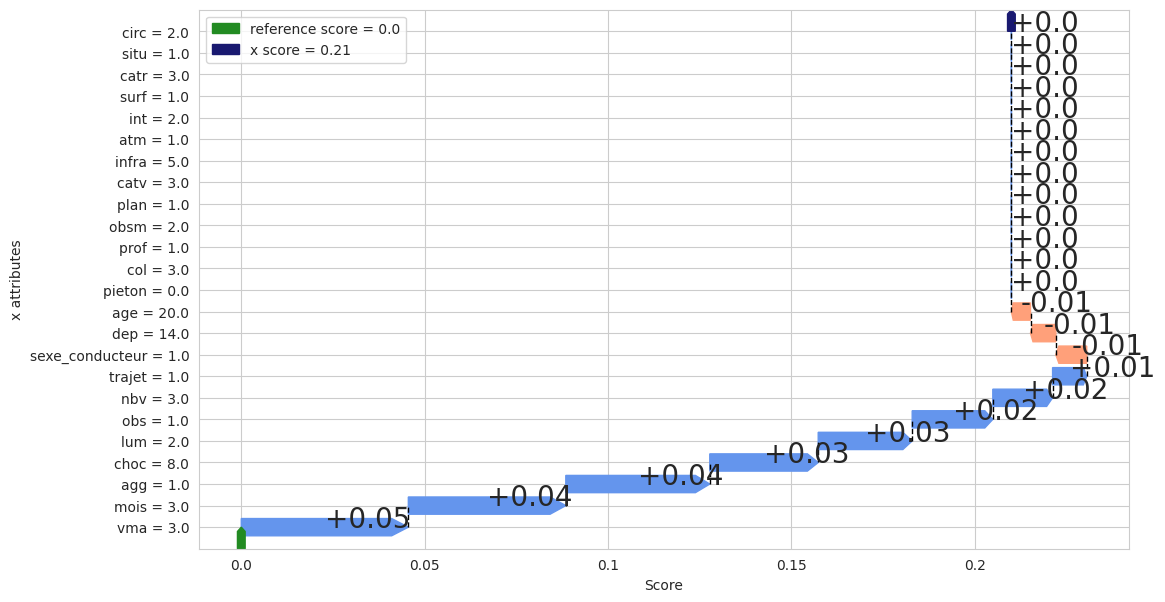

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



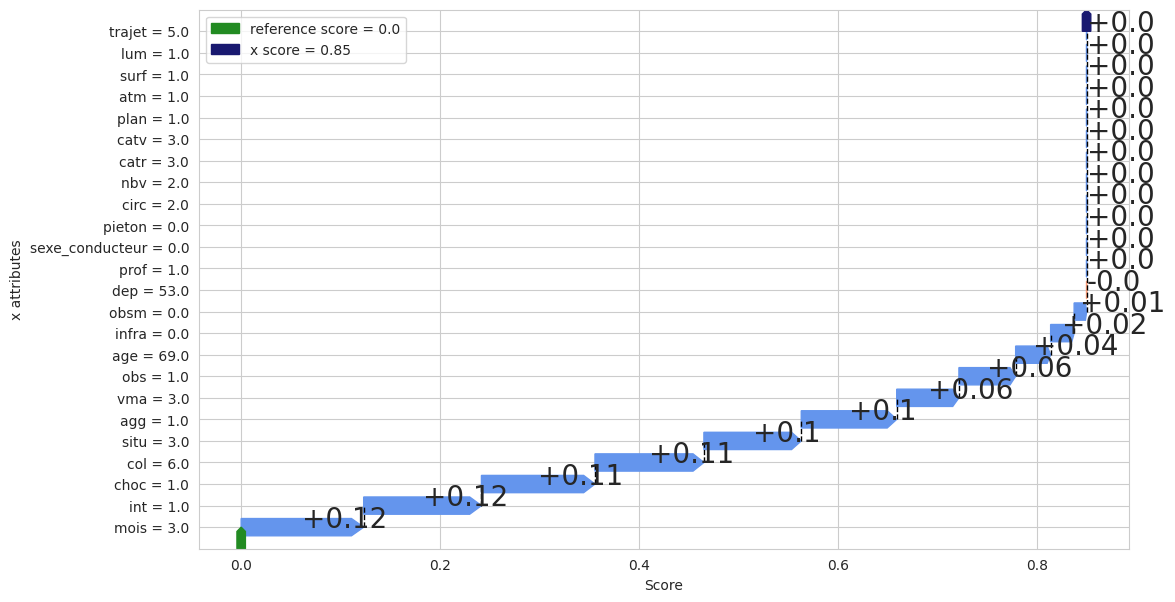

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



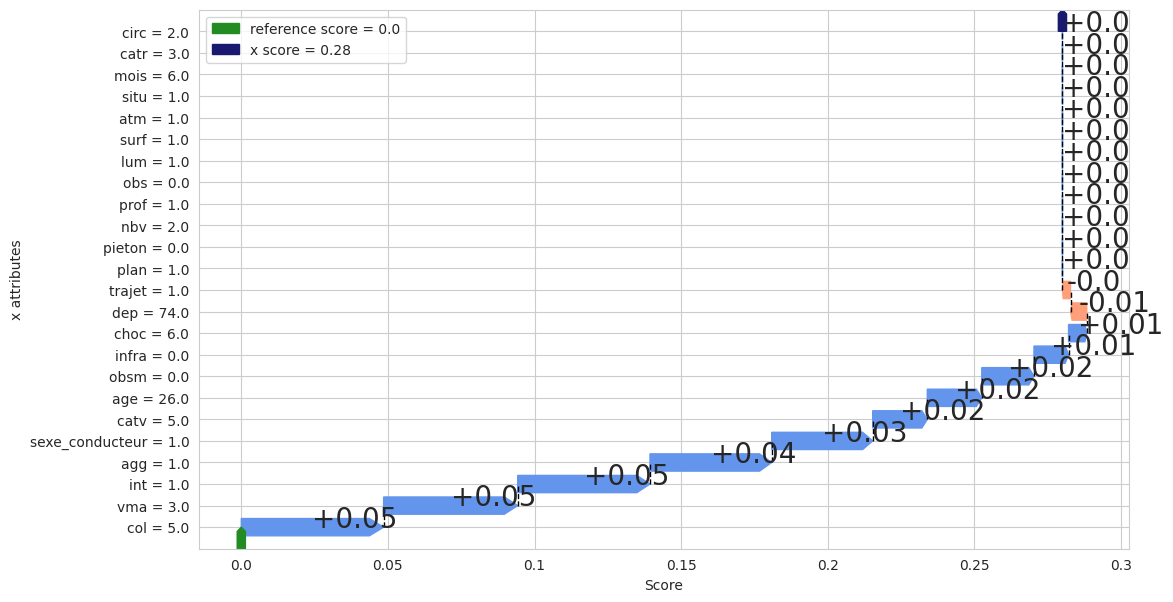

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



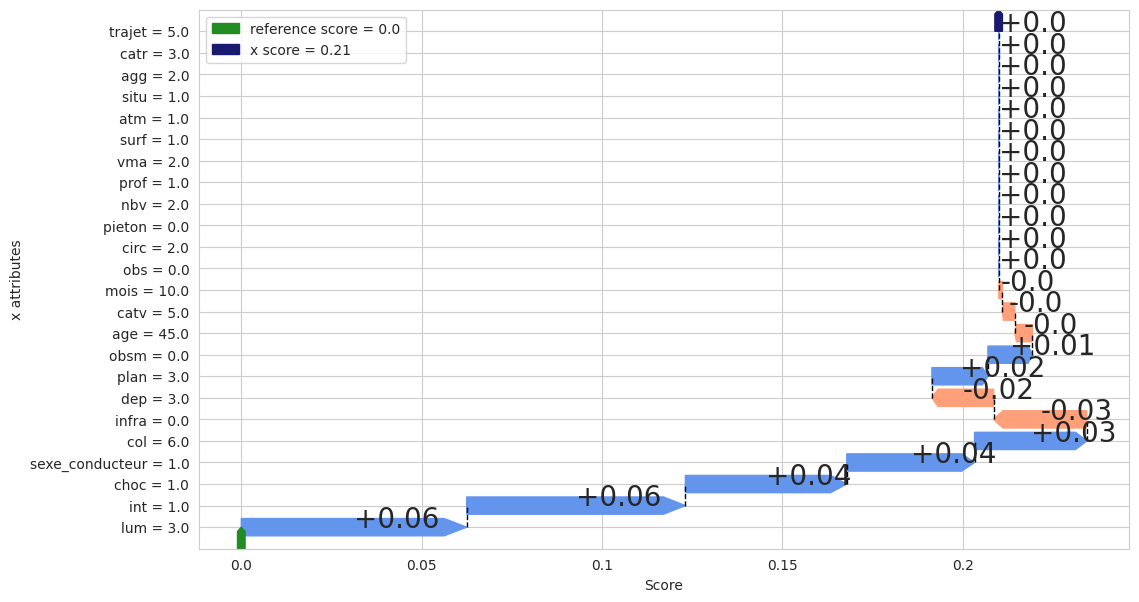

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



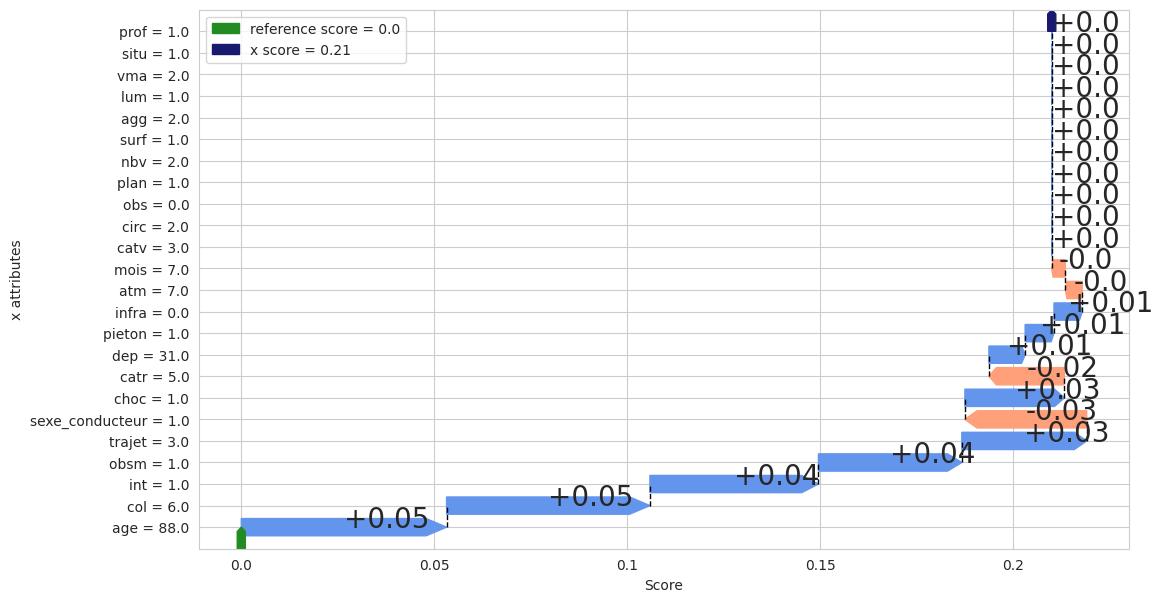

In [30]:
from shapkit.plots import plot_shapley

# Affichage des résultats
for i in range(0, 5):
    true_shap, query_instance, reference = s.results[i]
    fig = plot_shapley(x=query_instance, fc=s.fc, ref=reference, shapley_values=true_shap, n_attributes=24)

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



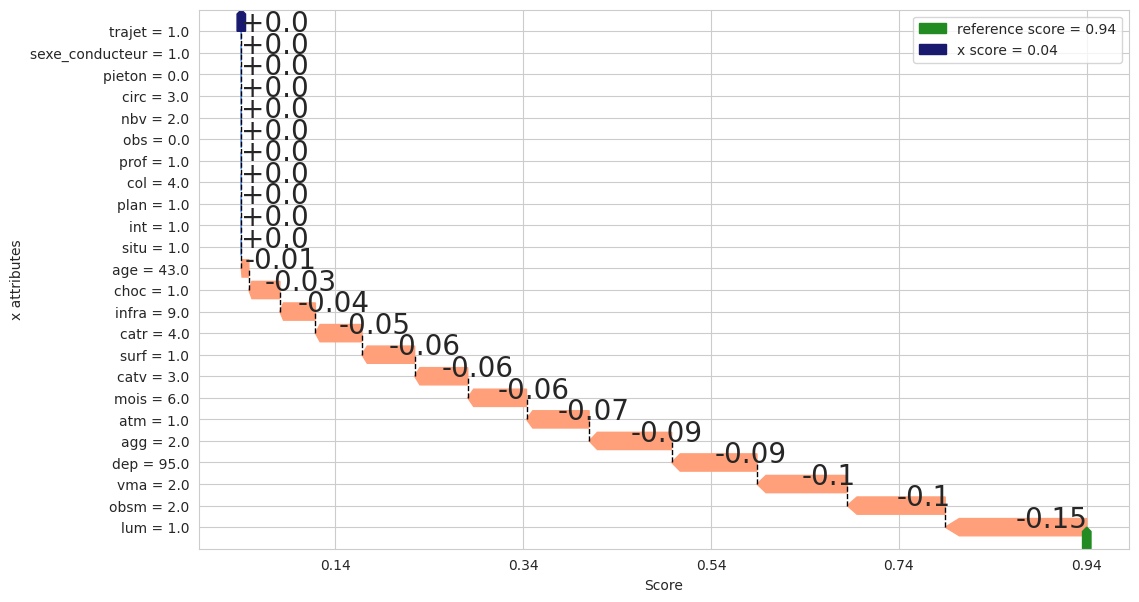

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



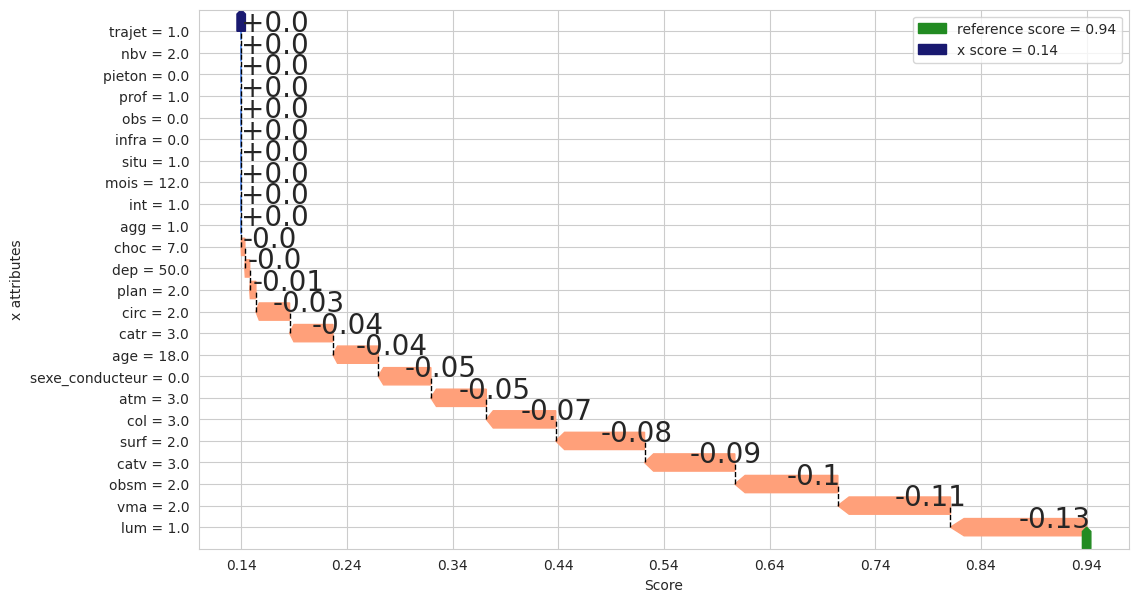

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



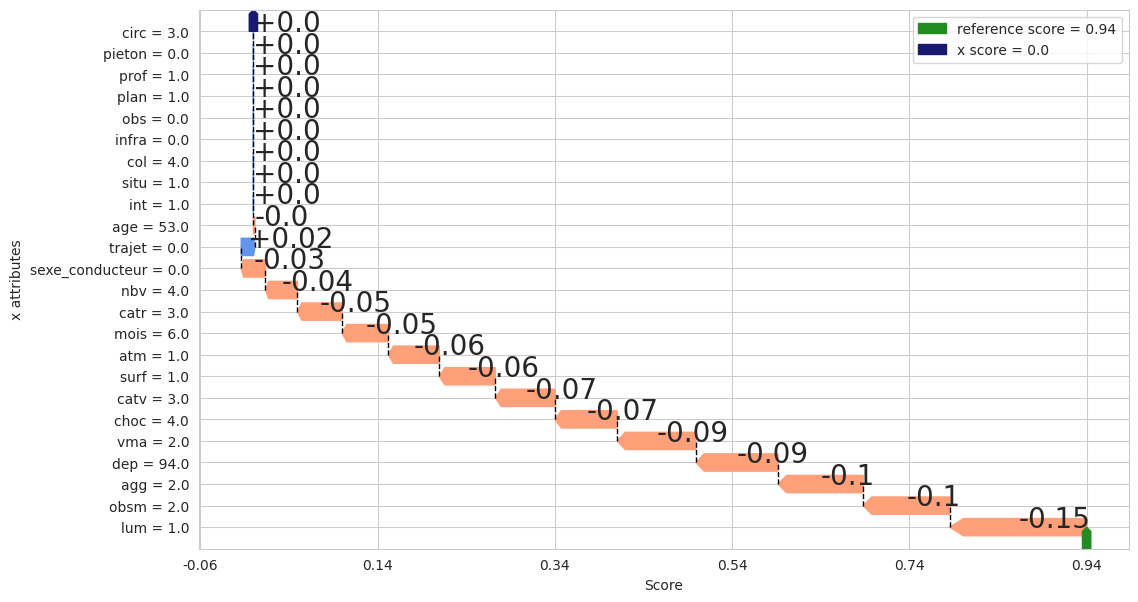

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



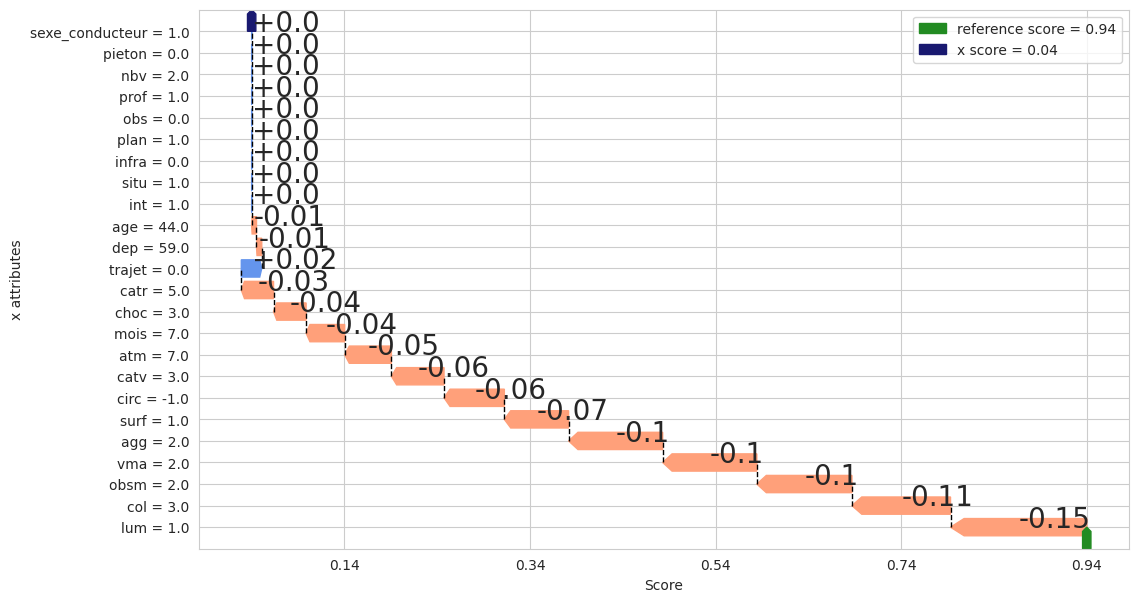

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:58: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:72: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/home/erwan/.local/lib/python3.10/site-packages/shapkit/plots.py:104: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



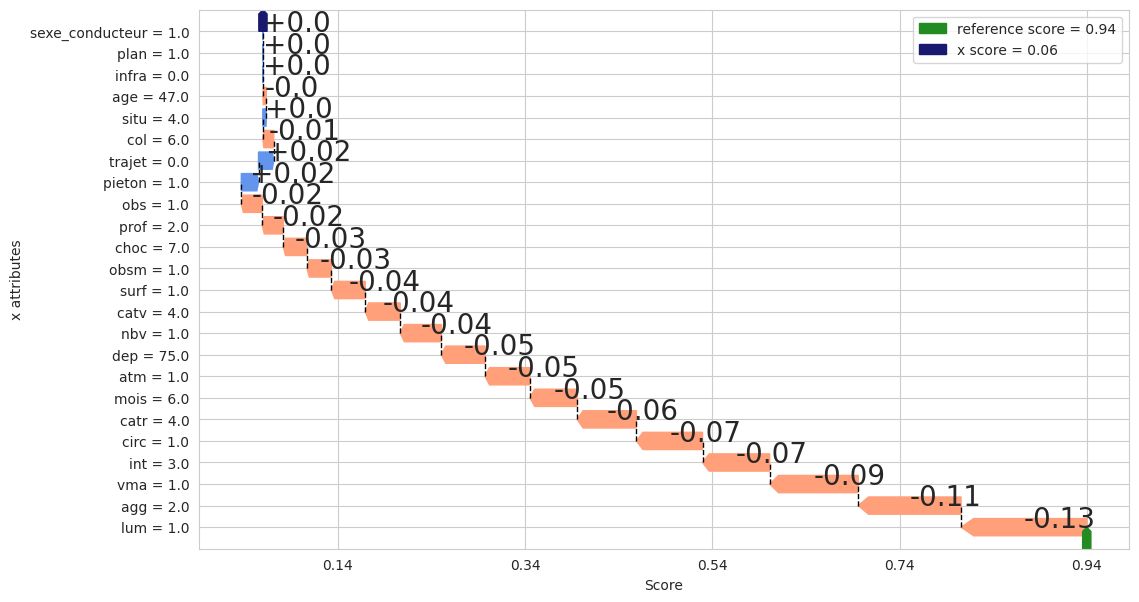

In [31]:
from shapkit.plots import plot_shapley

# Affichage des résultats
for i in range(0, 5):
    true_shap, query_instance, reference = s2.results[i]
    fig = plot_shapley(x=query_instance, fc=s2.fc, ref=reference, shapley_values=true_shap, n_attributes=24)

In [22]:
from BlackBoxAuditing.data import load_from_file
from BlackBoxAuditing.model_factories.AbstractModelFactory import AbstractModelFactory
from BlackBoxAuditing.model_factories.AbstractModelVisitor import AbstractModelVisitor

import BlackBoxAuditing as BBA


(_, train_BBA, _, _, _, _) = load_from_file("train_data.csv",
                      correct_types = np.repeat([int], [len(data_test.columns)]),
                                response_header = 'Y',
                               train_percentage = 1.0)
(headers, _, test_BBA, response_header, features_to_ignore, correct_types) = load_from_file("test_data.csv",
                      correct_types = np.repeat([int], [len(data_test.columns)]),
                                response_header = 'Y',
                               train_percentage = 0.0)
BBA_data = (headers, train_BBA, test_BBA, response_header, features_to_ignore, correct_types)

ValueError: invalid literal for int() with base 10: '2008.0'

In [34]:
class HirePredictorBuilder(AbstractModelFactory):
    def __init__(self, *args, **kwargs):
        AbstractModelFactory.__init__(self, *args, **kwargs)
        self.verbose_factory_name = "HirePredictor"
    def build(self, train_set):
        return HirePredictor()

class HirePredictor(AbstractModelVisitor):
    def __init__(self):
        with open( 'clf.pickle', 'rb' ) as f:
            self.clf = pickle.load(f)

    def test(self, test_set, test_name=""):
        df_test = pd.DataFrame(
            test_set, columns =data_test.columns.to_list())
        targets = df_test['Y']
        preds = self.clf.predict(df_test.drop('Y', axis=1))
        return [[a,b] for (a,b) in zip(targets, preds)]

In [97]:
auditor = BBA.Auditor()
auditor.ModelFactory = HirePredictorBuilder
auditor(BBA_data, output_dir = "audit-output")

NameError: name 'HirePredictorBuilder' is not defined